# Project: Investigate the medical no-show appointments dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this notebook we will investigate the medical no-show appointments dataset. This dataset contains details of close to a 100k medical appointments in Brazil. The dataset is maintained by [Kaggle here](https://www.kaggle.com/joniarroba/noshowappointments). It contains information about the patients and whether they showed up for the appointment. The data includes the scheduled day of appointment, neighborhood of the hospital and details on whether the patient has enrolled in the state sponsored welfare program. 

The **objective** of the data analysis is to understand the data and the relationship between them. The primary emphasis is to investigate the following:
* What features of the patient or the appointment have a relationship to no-show rate.We investigate to see if there are any features in the data that might predict the no-show status.

In addition we will figure out the following two questions along the way.
* What is the demographic of welfare recipients?
* What are the profiles of patients of certain illness?

Since this is just an **exploratory** analysis, there will not be any causal conclusions ( That will require more analytical and learning tasks). Most of what we identify will be statistical relationship betwen the features and the no-show status. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

Let us load the data and have a look at its general structure.

### General Properties

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
print(df.shape)
df.head()

(110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We have over a **100k rows** and **14 columns**

Let us have a look at the data types of the columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There are **no missing fields** in the data and the data seems quite clean. 

Let us add a few columns. 
    * AdvancedNotice : a new column that will give  the difference between the day on which the appointment is booked and the scheduled day
    * AppointmentWeekday: a new column to specify the day of the appointment

In [4]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
ns_series = pd.Series(np.zeros(len(df),dtype=np.int32))
ns_series[df['No-show']=='Yes']=1
df['NoShowInt'] = ns_series


timediff = df['AppointmentDay']-df['ScheduledDay']
timediff[timediff < pd.Timedelta(0)] = pd.Timedelta(0)
df['AdvancedNotice']= timediff.dt.days

df['AppointmentWeekday'] = df['AppointmentDay'].dt.weekday
print(df.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'NoShowInt', 'AdvancedNotice', 'AppointmentWeekday'],
      dtype='object')


Let us see the distribution of data with respect to no-shows. 

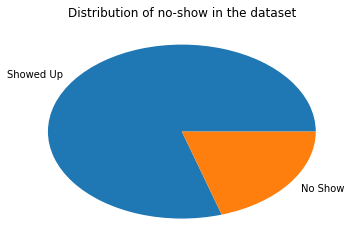

In [5]:
num_showed = (df['No-show']=='No').sum()
num_no_show = (df['No-show']=='Yes').sum()
plt.pie([num_showed,num_no_show],labels=['Showed Up','No Show'])
plt.title('Distribution of no-show in the dataset');

As we can see, close to a **quarter** of the appointments in the dataset were no-shows while the rest went through with the appointment.



<a id='eda'></a>
## Exploratory Data Analysis


### What affects the no-show rate?
Let us examine if any of the features show relationship with the no-show. Here are some quick graphs on the features and their no-show percentages

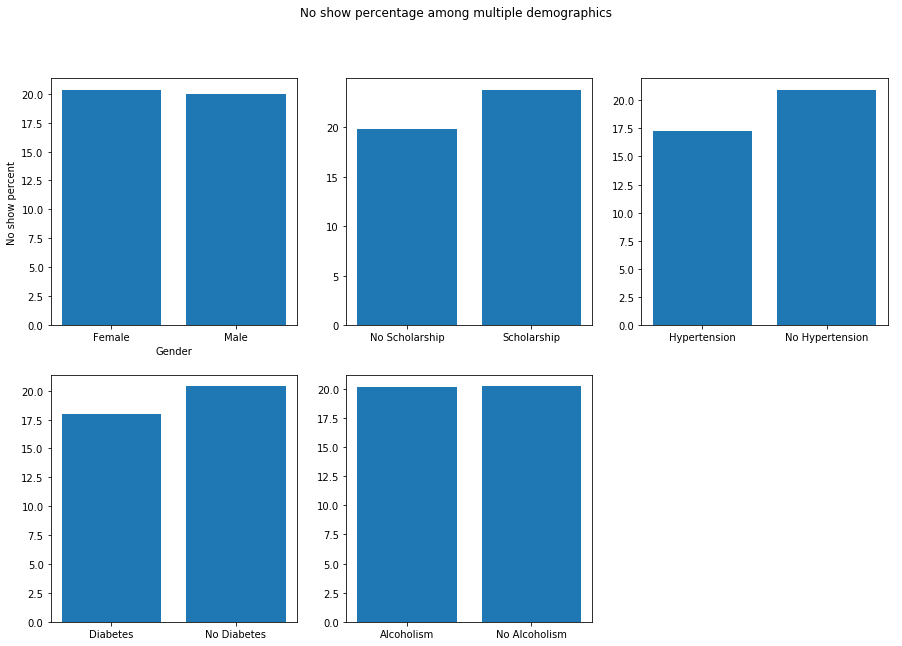

In [6]:
# This function returns the no-show proportion of the given field. For example, if the field is "Gender", it gives
# the proportion of males and females who did a no-show
def get_ns_percent(df,field):
    field_values = df[field].unique()
    grouped = df.groupby(['NoShowInt',field])[field].count()
    return (grouped[1]*100/(grouped[0]+grouped[1]))

fig = plt.figure(figsize=(15,10))
axes = fig.subplots(2,3)
axes[0][0].bar(['Female','Male'],get_ns_percent(df,'Gender'))
axes[0][0].set_xlabel("Gender")
axes[0][0].set_ylabel("No show percent")
axes[0][1].bar(['No Scholarship','Scholarship'],get_ns_percent(df,'Scholarship'))
axes[0][2].bar(['No Hypertension','Hypertension'],get_ns_percent(df,'Hipertension'))
axes[1][0].bar(['No Diabetes','Diabetes'],get_ns_percent(df,'Diabetes'))
axes[1][1].bar(['No Alcoholism','Alcoholism'],get_ns_percent(df,'Alcoholism'))
axes[1][2].axis('off')
fig.suptitle("No show percentage among multiple demographics",fontSize=16);

Let us briefly discuss each of the above:
* **Gender**: Both male and female patients have similar no-show percentages. 
* **Scholarship**: The people on Scholarship seem to have a **slightly higher no-show percentage** compared to those not on it. This could potentially be probed further.
* **HyperTension,Diabetes**: In both of these cases the patients with the disorder seem to have a slightly lower no-show percentage than those that do not have it. It just could be that they have a stronger need for apointment.
* **Alcoholism**: This seems to have no effect on the rate at which people show up for appointments.
* **Neighbourhood** values vary between a reasonably large range. However due to lack of further information about them, this notebook does not further investigate along it. 

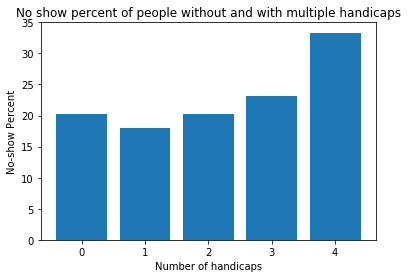

In [7]:
plt.bar([0,1,2,3,4],get_ns_percent(df,"Handcap"))
plt.title("No show percent of people without and with multiple handicaps")
plt.xlabel("Number of handicaps")
plt.ylabel("No-show Percent");

In the case of people with **disabilities**, we see that except for a dip for people with one disability, **as the number of disabilities increase, the no-show percent increases too**. Probably this indicates the need of support this demographic might need to show up.

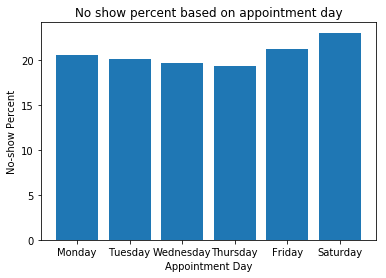

In [8]:
plt.bar(range(0,6),get_ns_percent(df,"AppointmentWeekday"),tick_label=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.title("No show percent based on appointment day")
plt.xlabel("Appointment Day")
plt.ylabel("No-show Percent");

As we see above, though the difference is not very high, the no-show rate seems to increase as the **appointment day  approaches the weekend**. 

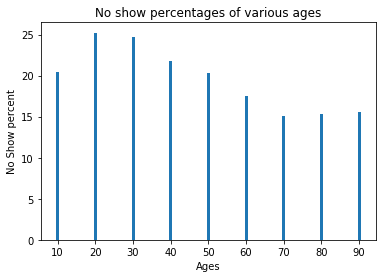

In [9]:
age_grouped = get_ns_percent(df,'Age')
ages=[]
mean_ns=[]
for x in range(10,100,10):
    ages.append(x)
    mean_ns.append(age_grouped.loc[x-10:x-1].mean())
plt.bar(ages,mean_ns)
plt.title('No show percentages of various ages')
plt.xlabel('Ages')
plt.ylabel('No Show percent');

The graph of no show percentage against **Age shows an interesting profile**. While the no-show for kids and elderly are low, it is high for middle aged persons. It could be that the parents are more prompt with their kids appointment and also the elderly, or the elderly being non-working are more prompt.

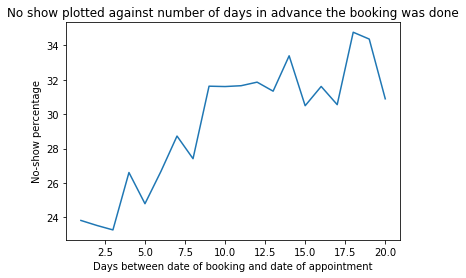

In [10]:
advanced_no_show = get_ns_percent(df,'AdvancedNotice').loc[1:20]
plt.plot(advanced_no_show);
plt.title("No show plotted against number of days in advance the booking was done")
plt.xlabel("Days between date of booking and date of appointment")
plt.ylabel("No-show percentage");

Though the curve is a bit zagged, in the near term(less than 20 days) we see that the **no-show percentage increases as the number of days in advance** that the appointment was booked. This is a resonable expectation.

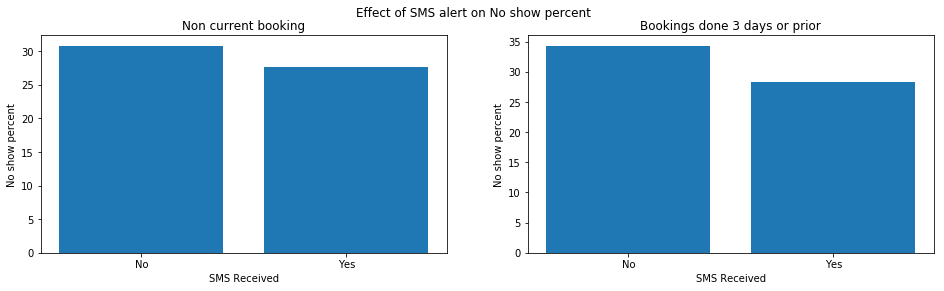

In [11]:
non_current_df = df[df.AdvancedNotice>0]
older_df = df[df.AdvancedNotice > 3]
fig = plt.figure(figsize=(16,4))
fig.suptitle("Effect of SMS alert on No show percent")
plts = fig.subplots(1,2)
plts[0].bar(['No','Yes'],get_ns_percent(non_current_df,'SMS_received'))
plts[0].set_xlabel("SMS Received")
plts[0].set_ylabel("No show percent")
plts[0].set_title("Non current booking");
plts[1].bar(['No','Yes'],get_ns_percent(older_df,'SMS_received'))
plts[1].set_xlabel("SMS Received")
plts[1].set_ylabel("No show percent")
plts[1].set_title("Bookings done 3 days or prior");

Patients have a **SMS alert** system. It reminds them of the appointment. The effect of the system on the no-show percentage is shown above. In the first plot we compare the effect of SMS on non-current booking(booking done atleast one day prior to appointment date). There is an effect that can be seen. In figure 2, we see the effect being more pronounced in appointments that were booked 3 days or prior. So the conclusion here is that for **appointments done in advance, SMS alert seems to have an effect in reducing no-show percentage**. 

### Patients demographic
The remainder of this notebook is an effort to understand demograpic of welfare recipients and people with certain illness. Before we do that, let us get a quick overview of the patients in the dataset.

Number of patients: 62299


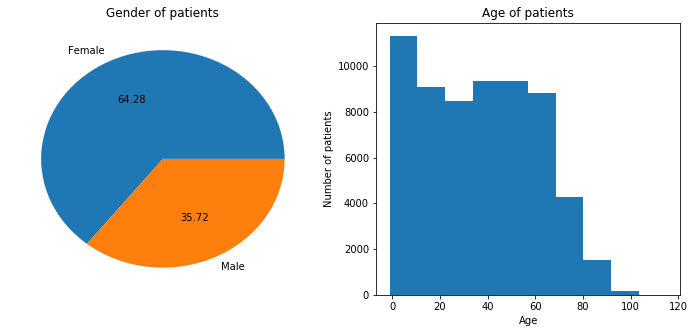

In [12]:
df_patients = df.groupby('PatientId').last().copy()
print('Number of patients:', len(df_patients))
fig = plt.figure(figsize = (12,5))
plts = fig.subplots(1,2)
plts[0].pie(df_patients.groupby('Gender')['Gender'].count(),labels=["Female","Male"],autopct='%0.2f');
plts[0].set_title("Gender of patients")
plts[1].hist(df_patients.Age)
plts[1].set_title('Age of patients');
plts[1].set_xlabel("Age")
plts[1].set_ylabel("Number of patients");

### What are the demographic of welfare recipients? 
The data contains a field called Scholarship. This field indicates if the patient is enrolled in Brazil's social welfare program called [Boisa Familia](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia). Let us see if we can gather demographic details about the recipients of this program

In [13]:
# This function gives the percentages of people with welfare and without welfare for a particular field.
# For example if the field is Diabetes, it gives the percent of people who have diabetes among population 
# vs those that have diabetes among welfare patients.
def get_wel_percent(df,field):
    field_values = df[field].unique()
    grouped = df.groupby([field,'Scholarship'])['Scholarship'].count()
    return (grouped[1]*100/(grouped[0]+grouped[1]))    

df_welfare = df_patients[df_patients.Scholarship==1].copy()
print("Total patients: ",len(df_patients))
print("Welfare recipients: ",len(df_welfare))

Total patients:  62299
Welfare recipients:  5788


We have data on **5788 welfare recipients**. Let us get a basic demographic familiarity about them. 

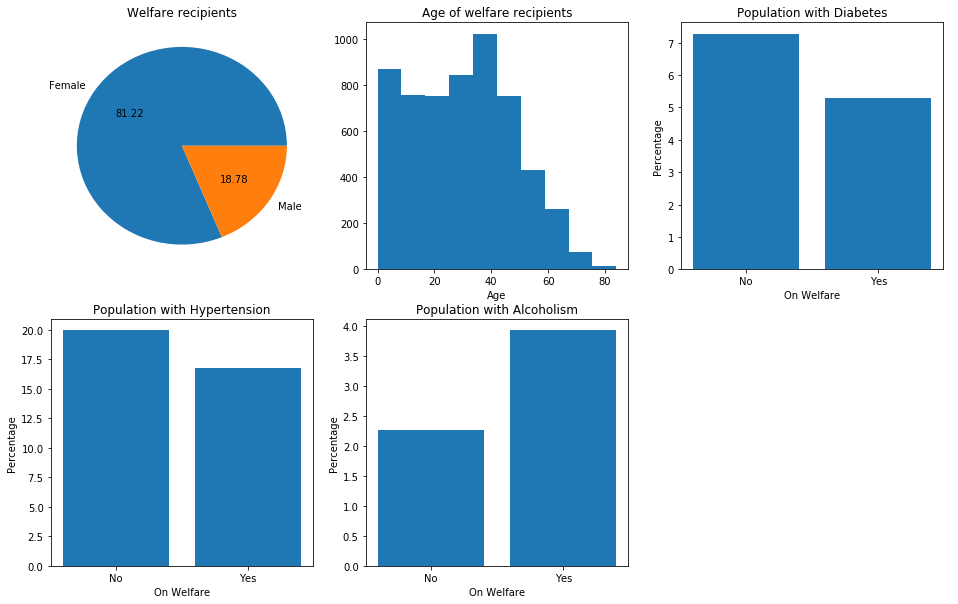

In [14]:
fig = plt.figure(figsize=(16,10))
plts = fig.subplots(2,3)
plts[0][0].pie(df_welfare.groupby('Gender')['Gender'].count(),labels=["Female","Male"],autopct='%0.2f');
plts[0][0].set_title("Welfare recipients");
plts[0][1].hist(df_welfare.Age);
plts[0][1].set_xlabel('Age')
plts[0][1].set_title("Age of welfare recipients");
plts[0][2].bar(["No","Yes"],get_wel_percent(df_patients,'Diabetes'))
plts[0][2].set_xlabel("On Welfare")
plts[0][2].set_ylabel("Percentage")
plts[0][2].set_title("Population with Diabetes");
plts[1][0].bar(["No","Yes"],get_wel_percent(df_patients,'Hipertension'))
plts[1][0].set_xlabel("On Welfare")
plts[1][0].set_ylabel("Percentage")
plts[1][0].set_title("Population with Hypertension");
plts[1][1].bar(["No","Yes"],get_wel_percent(df_patients,'Alcoholism'))
plts[1][1].set_xlabel("On Welfare")
plts[1][1].set_ylabel("Percentage")
plts[1][1].set_title("Population with Alcoholism");
plts[1][2].axis('off');

In the first chart above, we can notice that **predominant members of the welfare scheme are women**(The scheme is actually aimed at female parents). The percentage is above the overall patient percentage of 65.

In the second chart we see that a majority of the members are less than 40 years of age. The **age of the members are lower than population**. (The population has an IQR between 17-56 years while the welfare members have an IQR between 15 and 42 years). This again is intended as the program is aimed at kids and their parents.

The third and fourth chart show a lower incidence of occurance of Diabetes and hypertension among welfare recipients. This could have multiple reasons including the gender bias and age bias we see evident in first and second chart.

The fifth chart shows a **higher incidence of alcoholism** among welfare recipients. Again this data requires further study. This might be due to the age bias (they are younger) compared to the population. A possible other reason could be that due to the nature of the program, the members are poorer than the population.


### Demographic of patients with specific diseases
**Diabetes**

As seen below, nearly **7 percent** of patients have diabetes. This is slightly less than the global average of 8.5%- [source](https://www.who.int/news-room/fact-sheets/detail/diabetes). The gender composition does not stand out (69% women while total patients are 64% women). The IQR (middle 50%) of age among diabetics is between **54 and 71**. Also, the percentage of **diabetics who have hypertension is very high(81%) compared to the population percentage of 20%**. 

In [15]:
df_diabetes = df_patients[df_patients.Diabetes==1].copy()
print("Percent of patients with diabetes: ",len(df_diabetes)*100/len(df_patients))
print(df_diabetes.Gender.value_counts(normalize=True))
print("Average age of diabetics: ",df_diabetes.Age.mean())
print(df_diabetes.Age.quantile([0.25,0.75]))
print("Diabetes and hypertension: ", len(df_diabetes[df_diabetes.Hipertension==1])*100/len(df_diabetes))

Percent of patients with diabetes:  7.088396282444341
F    0.691123
M    0.308877
Name: Gender, dtype: float64
Average age of diabetics:  61.7361865942
0.25    54.0
0.75    71.0
Name: Age, dtype: float64
Diabetes and hypertension:  81.13677536231884


**Hypertension**

The occurance of Hypertension among the studied patients is much more than Diabetes. Close to 19% of the patients have hypertension (though this is lower than the global percentage of nearly 30 - [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4979614/) ). Again there is no marked Gender composition. The IQR of age of patients with Hypertension is between 52 and 71. The percentage of **people with hypertension who have diabetes** is 29% which is **significantly larger** than the overall percentage of 7%. 


In [16]:
df_hypertension = df_patients[df_patients.Hipertension==1].copy()
print("Percent of patients with hypertension: ",len(df_hypertension)*100/len(df_patients))
print(df_hypertension.Gender.value_counts(normalize=True))
print("Average age of hypertension: ",df_hypertension.Age.mean())
print(df_hypertension.Age.quantile([0.25,0.75]))
print("Hypertension and diabetes: ", len(df_hypertension[df_hypertension.Diabetes==1])*100/len(df_hypertension))

Percent of patients with hypertension:  19.650395672482706
F    0.695393
M    0.304607
Name: Gender, dtype: float64
Average age of hypertension:  61.1395196863
0.25    52.0
0.75    71.0
Name: Age, dtype: float64
Hypertension and diabetes:  29.268093448782878


**Alcoholism**

Close to 2.5% of the patients were diagnosed with Alcoholism. This seems to be higher than the global average of 1.3% - [source](https://ourworldindata.org/alcohol-consumption). The gender composition of those with alcoholism is **vastly different** from the patient composition. 62% of the patients diagnosed with alcoholism were male while males formed only 35% of the total patients. The IQR for age for those with alcoholism is between 40 and 59 years. While the percentage of alcoholics who have diabetes is slightly higher than all patients (11% vs 7%), there is a marked difference in case of Hypertension. The percent of **people with alcoholism who have Hypertension** is close to 40% which is **significantly larger** than among all patients(20%). 


In [17]:
df_alcoholism = df_patients[df_patients.Alcoholism==1].copy()
print("Percent of patients with alcoholism: ",len(df_alcoholism)*100/len(df_patients))
print(df_alcoholism.Gender.value_counts(normalize=True))
print("Average age of alcoholism: ",df_alcoholism.Age.mean())
print(df_alcoholism.Age.quantile([0.25,0.75]))
print("Alcoholism and diabetes: ", len(df_alcoholism[df_alcoholism.Diabetes==1])*100/len(df_alcoholism))
print("Alcoholism and hypertension: ", len(df_alcoholism[df_alcoholism.Hipertension==1])*100/len(df_alcoholism))

Percent of patients with alcoholism:  2.4173742756705563
M    0.622842
F    0.377158
Name: Gender, dtype: float64
Average age of alcoholism:  49.4727755644
0.25    40.00
0.75    58.75
Name: Age, dtype: float64
Alcoholism and diabetes:  11.354581673306773
Alcoholism and hypertension:  39.7078353253652


<a id='conclusions'></a>
## Conclusions

Through this notebook we did an Exploratory Data Analysis of the No-show data from Brazil medical appointments dataset. The approach was primarily limited to exploratory analysis using central tendency measures, proportions and visualizations. No hypothesis testing was done and no machine learning approaches were used. (The word "significant" used in the notebook do not mean "statistically significant"). Also the dataset is not necessarily indicative of the Brazilian population and so the conclusions do not necessarily apply to the population as a whole. Given these caveats, here are some of the summarized findings. 

We set out to investigate if any of the patient or appointment features had any impact on the No-Show percentage. Among the patient features, we saw that the No-Show percentage was lower when the patient was either a child or an elderly person. We also found that people with multiple disabilities had a higher propensity for no-show. Among welfare recipients we found a slightly higher no-show rate. Among appointment features, the farther away the appointment date from the scheduled date, the higher the no show rate and no show rates were higher during weekends. The SMS alert system seems to have an impact on reducing no-show rates, particularly if the appointment is more than a couple of days away. While all of these observations are potential areas of further study, both the strength of correlation as well as any particular predictive strength of these features is to be further worked on. 

Along with the above primary objective, we also had a quick look at the demographic of welfare recipients and people with certain illness. We noticed that the number of patients with alcoholism was more in welfare recipients. The co-occurance of diabetes and hypertension and of alcoholism and hypertension was noted to indicate a possible link. 

In [18]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0